In [0]:
! nvidia-smi

Tue May 26 08:01:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101
     |████████████████████████████████| 163kB 4.6MB/s 


In [0]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.83119 minutes


In [0]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


In [0]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 203 (delta 9), reused 0 (delta 0), pack-reused 178
Receiving objects: 100% (203/203), 12.64 MiB | 12.41 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [0]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src
dataset  __init__.py  losses  models


### Importing modules from github folders

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test

In [0]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs       = 96
bs_small = 96
bs_large = 16
rows = 5
img_save, model_save = 1500, 500
t0, t20k, t40k, t60k, t80k, t120k, t160k, t200k, t240k, t280k, t320k, t360k, t380k, t400k  = 0, 20000, 40000, 60000, 80000,  \
                                                                                        120000, 160000, 200000, 240000,\
                                                                                        280000, 320000, 360000, 380000, 400000

### Creating transforms. We are resizing images for faster training

In [0]:
transform_instance   = dtf.Transforms_custom()
before_norm_list     = [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)]

transform_mini     = transform_instance.data_transforms(64, 64, before_norm_list)
transform_small    = transform_instance.data_transforms(96, 96, before_norm_list)
transform_orig     = transform_instance.data_transforms(192, 192, before_norm_list)
transform_test     = transform_instance.test_transforms(64,64)

### Creating dataloader for each size of images (resized using transforms).

In [0]:
train_ds_mini  = md.Makedata(f1, content_list, t0, t20k, transform_mini)
train_ds_small = md.Makedata(f1, content_list, t20k, t40k, transform_small)
train_ds_orig  = md.Makedata(f1, content_list, t40k, t60k, transform_orig)
test_ds        = md.Makedata(f1, content_list, t380k, t400k, transform_test)     

In [0]:
train_dl_mini  = DataLoader(train_ds_mini, batch_size = bs, shuffle = True, pin_memory = True)
train_dl_small = DataLoader(train_ds_small, batch_size = bs_small, shuffle = True, pin_memory = True)
train_dl_orig  = DataLoader(train_ds_orig, batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl        = DataLoader(test_ds, batch_size = bs, shuffle = True, pin_memory = True)

### Doing a quick check if tensor shapes are as expected

In [0]:
images_mini  = next(iter(train_dl_mini))
images_small = next(iter(train_dl_small))
images_orig  = next(iter(train_dl_orig))
images_test  = next(iter(test_dl))
print('Mini:',[(k, v.shape) for k, v in images_mini.items()])
print('Small:',[(k, v.shape) for k, v in images_small.items()])
print('Orig:',[(k, v.shape) for k, v in images_orig.items()])
print('Test:',[(k, v.shape) for k, v in images_test.items()])

Mini: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
Small: [('f1', torch.Size([96, 3, 96, 96])), ('f2', torch.Size([96, 3, 96, 96])), ('f3', torch.Size([96, 1, 96, 96])), ('f4', torch.Size([96, 1, 96, 96]))]
Orig: [('f1', torch.Size([16, 3, 192, 192])), ('f2', torch.Size([16, 3, 192, 192])), ('f3', torch.Size([16, 1, 192, 192])), ('f4', torch.Size([16, 1, 192, 192]))]
Test: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]


In [0]:
imgs = images_orig['f1']

### Displaying images to see if images are coming out as expected

In [0]:
def show(tensors, figsize= (10,10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

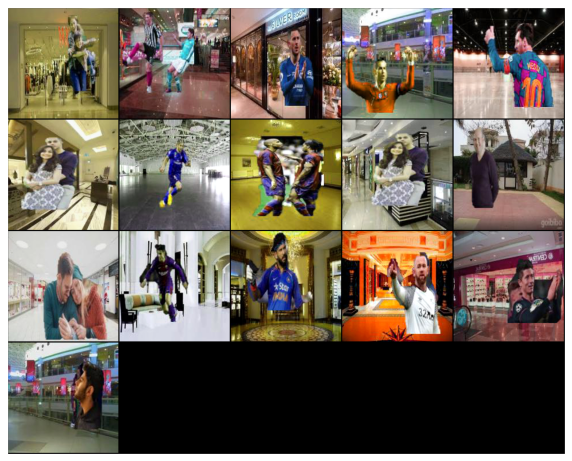

In [0]:
show(imgs, nrow=rows)

In [0]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

In [0]:
def freeze_mask_layers():
    print('Freezing Mask Layers')
    for param in model.convA.parameters():
      param.requires_grad = False
    for param in model.convB.parameters():
      param.requires_grad = False
    for param in model.convC.parameters():
      param.requires_grad = False
    for param in model.convD.parameters():
      param.requires_grad = False
    for param in model.convE.parameters():
      param.requires_grad = False
    #    
    for param in model.blck1.parameters():
      param.requires_grad = True
    for param in model.blck2.parameters():
      param.requires_grad = True
    for param in model.blck3.parameters():
      param.requires_grad = True
    for param in model.blck4.parameters():
      param.requires_grad = True
    for param in model.blck5.parameters():
      param.requires_grad = True  
    for param in model.blck6.parameters():
      param.requires_grad = True
    for param in model.blck7.parameters():
      param.requires_grad = True
    for param in model.blck8.parameters():
      param.requires_grad = True
    for param in model.convLast.parameters():
      param.requires_grad = True          

In [0]:
def freeze_depth_layers():
    print('Freezing Depth Layers')
    for param in model.convA.parameters():
      param.requires_grad = True
    for param in model.convB.parameters():
      param.requires_grad = True
    for param in model.convC.parameters():
      param.requires_grad = True
    for param in model.convD.parameters():
      param.requires_grad = True
    for param in model.convE.parameters():
      param.requires_grad = True  
    #    
    for param in model.blck1.parameters():
      param.requires_grad = False
    for param in model.blck2.parameters():
      param.requires_grad = False
    for param in model.blck3.parameters():
      param.requires_grad = False
    for param in model.blck4.parameters():
      param.requires_grad = False
    for param in model.blck5.parameters():
      param.requires_grad = False  
    for param in model.blck6.parameters():
      param.requires_grad = False
    for param in model.blck7.parameters():
      param.requires_grad = False
    for param in model.blck8.parameters():
      param.requires_grad = False
    for param in model.convLast.parameters():
      param.requires_grad = False    

In [0]:
#criterion  = nn.BCEWithLogitsLoss()
criterion1  = DiceLoss()
kernel_size = 3
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

In [0]:
#train_loss_fn = Train.Train_loss()
#test_loss_fn  = Test.Test_loss()

In [0]:
def draw_and_save(tensors, name, figsize=(15,15), *args, **kwargs):
          try:
            tensors = tensors.detach().cpu()
          except:
            pass
          grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
          grid_image  = grid_tensor.permute(1, 2, 0)
          plt.figure(figsize = figsize)
          plt.imshow(grid_image)
          plt.xticks([])
          plt.yticks([])

          plt.savefig(name, bbox_inches='tight')
          plt.close()
         #plt.show()            

In [0]:
# # class for Calculating and storing training losses and training accuracies of model for each batch per epoch ## 
class Training_loss: 
    def train_loss_calc(self,model, device, train_loader, optimizer, epoch, criterion1, criterion2, batch_size, path_name,path_model_save,
                        scheduler=None, model_save_idx=500, img_save_idx=500,maxlr=0):
                        
          self.model        = model
          self.device       = device
          self.train_loader = train_loader
          self.optimizer    = optimizer
          self.epoch        = epoch
          self.criterion1   = criterion1
          self.criterion2   = criterion2
          self.scheduler    = scheduler
          self.model_save_idx    = model_save_idx
          self.img_save_idx      = img_save_idx
          self.maxlr        = maxlr
          self.batch_size   = batch_size
          self.path_name    = path_name
          self.path_model_save = path_model_save
        
          model.train()
          train_loss1, train_loss2, train_loss, train_mask_iou_cum, train_depth_iou_cum = 0, 0, 0, 0, 0
          pbar = tqdm(train_loader)
          num_batches = len(train_loader.dataset)/batch_size
          cuda0 = torch.device('cuda:0')           

          for batch_idx, data in enumerate(pbar):
            data['f1'] = data['f1'].to(cuda0)
            data['f2'] = data['f2'].to(cuda0)
            data['f3'] = data['f3'].to(cuda0)
            data['f4'] = data['f4'].to(cuda0)
            data['f3O'] = torch.tensor(data['f3'],dtype= torch.int64, device= cuda0)

            optimizer.zero_grad()
            output = model(data)

            loss1 = criterion1(output[0], data['f3O'])
            loss2 = criterion2(output[1], data['f4'])
            loss  = 2*loss1 + loss2
            train_loss1 += loss1
            train_loss2 += loss2
            train_loss  += loss
            mask_iou   = self.calculate_iou(data['f3O'].detach().cpu().numpy(), output[0].detach().cpu().numpy())
            depth_iou  = self.calculate_iou(data['f4'].detach().cpu().numpy(),  output[1].detach().cpu().numpy())
            train_mask_iou_cum  += mask_iou
            train_depth_iou_cum += depth_iou

            pbar.set_description(desc = f'TR{int(epoch)}|{int(batch_idx)}|{loss1:.3f}|{loss2:.3f}|{mask_iou:.3f}|{depth_iou:.3f}') 
                                          
            loss.backward()
            optimizer.step()
            
            if batch_idx % img_save_idx == 0 or batch_idx == int(num_batches-1):
                print('Train Epoch:{} Batch_ID: {} [{}/{} ({:.0f}%)]\tLoss:{:.5f} Mask_Loss:{:.5f} Dpth_Loss:{:.5f} Mask_IOU:{:.5f} Dpth_IOU: {:.5F}'
                      .format(epoch, batch_idx, batch_idx * batch_size, len(train_loader.dataset), (100. * batch_idx / len(train_loader)),
                       loss, loss1, loss2, mask_iou, depth_iou))
                draw_and_save(output[0].detach().cpu(),  f'{path_name}{epoch}_{batch_idx}_MP_{loss.item():.5f}.jpg')
                draw_and_save(data['f3'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_MA_{loss.item():.5f}.jpg')
                draw_and_save(output[1].detach().cpu(),  f'{path_name}{epoch}_{batch_idx}_DP_{loss.item():.5f}.jpg')
                draw_and_save(data['f4'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_DA_{loss.item():.5f}.jpg')
                draw_and_save(data['f1'].detach().cpu(), f'{path_name}{epoch}_{batch_idx}_FGBG_{loss.item():.5f}.jpg')    
              
            if batch_idx % model_save_idx == 0:
              torch.save(model.state_dict(),path_model_save)
              print('MODEL SAVED:',path_model_save, 'Epoch & Batch-ID:', epoch, batch_idx)
              
          #train_loss       /= len(train_loader.dataset)
          train_loss       /= num_batches
          train_mask_loss   = train_loss1/num_batches
          train_depth_loss  = train_loss2/num_batches
          train_mask_iou    = train_mask_iou_cum/num_batches
          train_depth_iou   = train_depth_iou_cum/num_batches 
          return train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou   

    def calculate_iou(self, target, prediction, thresh=0.5):
        '''
        Calculate intersection over union value
        :param target: ground truth
        :param prediction: output predicted by model
        :param thresh: threshold
        :return: iou value
        '''
        intersection = np.logical_and(np.greater(target, thresh), np.greater(prediction, thresh))
        union = np.logical_or(np.greater(target, thresh), np.greater(prediction, thresh))
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score

In [0]:
# # class for Calculating and storing testing losses and testing accuracies of model for each epoch ## 
class Testing_loss:

      def test_loss_calc(self,model, device, test_loader, optimizer, epoch, criterion1, criterion2, batch_size, path_name, scheduler=None, img_save_idx =500):
          self.model        = model
          self.device       = device
          self.test_loader  = test_loader
          self.optimizer    = optimizer
          self.epoch        = epoch
          self.criterion1   = criterion1
          self.criterion1   = criterion2           
          self.scheduler    = scheduler
          self.batch_size   = batch_size
          self.path_name    = path_name
          self.img_save_idx = img_save_idx

          model.eval()  
          test_loss1, test_loss2, test_loss, test_mask_iou_cum, test_depth_iou_cum = 0, 0, 0, 0, 0
          pbar = tqdm(test_loader)
          num_batches = len(test_loader.dataset)/batch_size
          cuda0 = torch.device('cuda:0')

          with torch.no_grad():
            for batch_idx, data in enumerate(pbar):
              data['f1'] = data['f1'].to(cuda0)
              data['f2'] = data['f2'].to(cuda0)
              data['f3'] = data['f3'].to(cuda0)
              data['f4'] = data['f4'].to(cuda0)      
              data['f3O'] = torch.tensor(data['f3'],dtype= torch.int64, device= cuda0)      
            
              output = model(data)

              loss1 = criterion1(output[0], data['f3O'])
              loss2 = criterion2(output[1], data['f4'])
              loss  = 2*loss1 + loss2
              test_loss1 += loss1
              test_loss2 += loss2
              test_loss  += loss
              mask_iou   = self.calculate_iou(data['f3O'].detach().cpu().numpy(), output[0].detach().cpu().numpy())
              depth_iou  = self.calculate_iou(data['f4'].detach().cpu().numpy(),  output[1].detach().cpu().numpy())
              test_mask_iou_cum  += mask_iou
              test_depth_iou_cum += depth_iou

              pbar.set_description(desc = f'TS{int(epoch)}|{int(batch_idx)}|{loss1:.3f}|{loss2:.3f}|{mask_iou:.3f}|{depth_iou:.3f}')   
              
              if batch_idx % img_save_idx == 0:
                  print('Test Epoch: {} [{}/{} ({:.0f}%)]\tTest_Loss: {:.6f} Mask_Loss: {:.5f} Dpth_Loss: {:.5f} Mask_IOU: {:.5f} Dpth_IOU: {:.5F}'
                         .format(epoch, batch_idx * len(data), len(test_loader.dataset), (100. * batch_idx / len(test_loader)),
                                 loss.item(), loss1.item(), loss2.item(),mask_iou, depth_iou ))
                  draw_and_save(output[0].detach().cpu(),  f'{path_name}Test_{epoch}_{batch_idx}_MP_{loss.item():.5f}.jpg')
                  draw_and_save(data['f3'].detach().cpu(), f'{path_name}Test_{epoch}_{batch_idx}_MA_{loss.item():.5f}.jpg')
                  draw_and_save(output[1].detach().cpu(),  f'{path_name}Test_{epoch}_{batch_idx}_DP_{loss.item():.5f}.jpg')
                  draw_and_save(data['f4'].detach().cpu(), f'{path_name}Test_{epoch}_{batch_idx}_DA_{loss.item():.5f}.jpg')
                  draw_and_save(data['f1'].detach().cpu(), f'{path_name}Test_{epoch}_{batch_idx}_FGBG_{loss.item():.5f}.jpg')       
            
          #test_loss      /= len(test_loader.dataset)
          test_loss      /= num_batches
          test_mask_loss  = test_loss1/num_batches
          test_depth_loss = test_loss2/num_batches
          test_mask_iou   = test_mask_iou_cum/num_batches
          test_depth_iou  = test_depth_iou_cum/num_batches
          return test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou

      def calculate_iou(self, target, prediction, thresh=0.5):
        '''
        Calculate intersection over union value
        :param target: ground truth
        :param prediction: output predicted by model
        :param thresh: threshold
        :return: iou value
        '''
        intersection = np.logical_and(np.greater(target, thresh), np.greater(prediction, thresh))
        union = np.logical_or(np.greater(target, thresh), np.greater(prediction, thresh))
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score             

In [0]:
train_loss_fn = Training_loss()
test_loss_fn  = Testing_loss()

In [0]:
'''
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0524V7I.pt'
model.load_state_dict(torch.load(path))

In [0]:
'''
path_name       = '/content/gdrive/My Drive/plots_0525_V11B_Test/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0525V11A.pt'
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,7):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size = bs
     freeze_mask_layers()
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device,train_dl_mini,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 3:
     batch_size = bs_small
     freeze_mask_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_small,                          \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 4:
     batch_size = bs_large
     freeze_mask_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_orig,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 5:
     batch_size = bs
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_mini,                          \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 6:
     batch_size = bs_small
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_small,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 7:
     batch_size = bs_large
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_orig,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)             

  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(              \
                                                         model, model.device, test_dl, optim,                           \
                                                         epoch, criterion1, criterion2, path_name,                      \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

Freezing Mask Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 0 [0/20000 (0%)]	Loss:0.24256 Mask_Loss:0.04872 Dpth_Loss:0.14511 Mask_IOU:0.31912 Dpth_IOU: 0.44522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11A.pt Epoch & Batch-ID: 1 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 207 [19872/20000 (99%)]	Loss:0.18985 Mask_Loss:0.03350 Dpth_Loss:0.12284 Mask_IOU:0.23307 Dpth_IOU: 0.57175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [0/20000 (0%)]	Test_Loss: 0.247545 Mask_Loss: 0.06277 Dpth_Loss: 0.12201 Mask_IOU: 0.56679 Dpth_IOU: 0.48485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Freezing Mask Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 0 [0/20000 (0%)]	Loss:0.24636 Mask_Loss:0.04967 Dpth_Loss:0.14703 Mask_IOU:0.29998 Dpth_IOU: 0.37905


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11A.pt Epoch & Batch-ID: 2 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 207 [19872/20000 (99%)]	Loss:0.20422 Mask_Loss:0.04636 Dpth_Loss:0.11150 Mask_IOU:0.29118 Dpth_IOU: 0.52077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [0/20000 (0%)]	Test_Loss: 0.280193 Mask_Loss: 0.06344 Dpth_Loss: 0.15332 Mask_IOU: 0.57143 Dpth_IOU: 0.31584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Freezing Mask Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 0 [0/20000 (0%)]	Loss:0.24157 Mask_Loss:0.05042 Dpth_Loss:0.14072 Mask_IOU:0.33829 Dpth_IOU: 0.32166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11A.pt Epoch & Batch-ID: 3 0
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11A.pt Epoch & Batch-ID: 3 500
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11A.pt Epoch & Batch-ID: 3 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.12612 Mask_Loss:0.01270 Dpth_Loss:0.10071 Mask_IOU:0.11465 Dpth_IOU: 0.37463



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [0/20000 (0%)]	Test_Loss: 0.322682 Mask_Loss: 0.06021 Dpth_Loss: 0.20227 Mask_IOU: 0.55406 Dpth_IOU: 0.00032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Freezing Depth Layers


RuntimeError: ignored

In [0]:
'''
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

train_loss_all: [0.002136985771358013, 0.0020236624404788017, 0.011934563517570496]
train_mask_loss_all: [0.0003925299970433116, 0.0004075971955899149, 0.0026440997608006]
train_depth_loss_all: [0.0013519265921786427, 0.0012084685731679201, 0.006646361202001572]
train_mask_iou_all: [0.002757924323872586, 0.0027728743887482678, 0.015634651221929276]
train_depth_iou_all: [0.005219341658240432, 0.0048071703098756455, 0.02206096900291496]
test_loss_all: [0.002583184279501438, 0.002884927671402693, 0.003354752203449607]
test_mask_loss_all: [0.0006516706198453903, 0.0006482605822384357, 0.0006499599548988044]
test_depth_loss_all: [0.0012798432726413012, 0.0015884058084338903, 0.002054833108559251]
test_mask_iou_all: [0.0059780816257192495, 0.005848805199687221, 0.005739895594387089]
test_depth_iou_all: [0.005073965523916356, 0.003289627010576099, 1.2988784498254317e-06]


In [0]:
'''
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0525V11A.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
'''
path_name       = '/content/gdrive/My Drive/plots_0525_V11B/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt'
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(3,7):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size = bs
     freeze_mask_layers()
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device,train_dl_mini,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 3:
     batch_size = bs_small
     freeze_mask_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_small,                          \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 4:
     batch_size = bs_large
     freeze_mask_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_orig,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 5:
     batch_size = bs
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_mini,                          \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 6:
     batch_size = bs_small
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_small,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 7:
     batch_size = bs_large
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_orig,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)             

  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(              \
                                                         model, model.device, test_dl, optim,                           \
                                                         epoch, criterion1, criterion2, path_name,                      \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

Freezing Mask Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 0 [0/20000 (0%)]	Loss:0.17884 Mask_Loss:0.03943 Dpth_Loss:0.09998 Mask_IOU:0.25772 Dpth_IOU: 0.40323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt Epoch & Batch-ID: 3 0
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt Epoch & Batch-ID: 3 500
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt Epoch & Batch-ID: 3 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.16009 Mask_Loss:0.02716 Dpth_Loss:0.10577 Mask_IOU:0.12274 Dpth_IOU: 0.36815



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [0/20000 (0%)]	Test_Loss: 0.322679 Mask_Loss: 0.06512 Dpth_Loss: 0.19243 Mask_IOU: 0.55824 Dpth_IOU: 0.00144

Freezing Depth Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 0 [0/20000 (0%)]	Loss:0.25138 Mask_Loss:0.03962 Dpth_Loss:0.17214 Mask_IOU:0.29041 Dpth_IOU: 0.26876


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt Epoch & Batch-ID: 4 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 207 [19872/20000 (99%)]	Loss:0.23439 Mask_Loss:0.03389 Dpth_Loss:0.16662 Mask_IOU:0.22937 Dpth_IOU: 0.30628


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [0/20000 (0%)]	Test_Loss: 0.292638 Mask_Loss: 0.06369 Dpth_Loss: 0.16525 Mask_IOU: 0.58479 Dpth_IOU: 0.28585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Freezing Depth Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:5 Batch_ID: 0 [0/20000 (0%)]	Loss:0.21277 Mask_Loss:0.04261 Dpth_Loss:0.12756 Mask_IOU:0.30979 Dpth_IOU: 0.33851
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt Epoch & Batch-ID: 5 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:5 Batch_ID: 207 [19872/20000 (99%)]	Loss:0.20488 Mask_Loss:0.03843 Dpth_Loss:0.12803 Mask_IOU:0.25795 Dpth_IOU: 0.32921


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 5 [0/20000 (0%)]	Test_Loss: 0.303550 Mask_Loss: 0.06051 Dpth_Loss: 0.18253 Mask_IOU: 0.54962 Dpth_IOU: 0.01082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Freezing Depth Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:6 Batch_ID: 0 [0/20000 (0%)]	Loss:0.19585 Mask_Loss:0.04979 Dpth_Loss:0.09628 Mask_IOU:0.28635 Dpth_IOU: 0.38344
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt Epoch & Batch-ID: 6 0
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt Epoch & Batch-ID: 6 500
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11B.pt Epoch & Batch-ID: 6 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:6 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.17468 Mask_Loss:0.03663 Dpth_Loss:0.10142 Mask_IOU:0.22065 Dpth_IOU: 0.36592



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 6 [0/20000 (0%)]	Test_Loss: 0.316061 Mask_Loss: 0.05994 Dpth_Loss: 0.19618 Mask_IOU: 0.54772 Dpth_IOU: 0.00036



In [0]:
'''
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

train_loss_all: [0.011684039607644081, 0.0025246257428079844, 0.002159608295187354, 0.011599233373999596]
train_mask_loss_all: [0.0026395844761282206, 0.0003894442634191364, 0.00040673173498362303, 0.0026069115847349167]
train_depth_loss_all: [0.00640487065538764, 0.0017457373905926943, 0.001346144126728177, 0.006385404150933027]
train_mask_iou_all: [0.1227405167925614, 0.17184717500404728, 0.2008954257767549, 0.22065482753189478]
train_depth_iou_all: [0.3681500314131207, 0.33140340185051803, 0.3616355398885989, 0.3659195106581024]
test_loss_all: [0.003308233106508851, 0.0029677439015358686, 0.0032001864165067673, 0.0033135751727968454]
test_mask_loss_all: [0.0006474382826127112, 0.0006486242637038231, 0.0006513592088595033, 0.0006488610524684191]
test_depth_loss_all: [0.002013356424868107, 0.0016704947920516133, 0.001897467183880508, 0.002015851903706789]
test_mask_iou_all: [0.5756570735708427, 0.5535099919478809, 0.568602377012186, 0.5794411937818094]
test_depth_iou_all: [0.000179125

In [0]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0525_V11C/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt'
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(7,13):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 8:
     batch_size = bs
     freeze_mask_layers()
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device,train_dl_mini,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 9:
     batch_size = bs_small
     freeze_mask_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_small,                          \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 10:
     batch_size = bs_large
     freeze_mask_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_orig,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 11:
     batch_size = bs
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_mini,                          \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 12:
     batch_size = bs_small
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_small,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 13:
     batch_size = bs_large
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_orig,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)             

  batch_size = bs
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(              \
                                                         model, model.device, test_dl, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,           \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

Freezing Mask Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:7 Batch_ID: 0 [0/20000 (0%)]	Loss:0.24786 Mask_Loss:0.03891 Dpth_Loss:0.17004 Mask_IOU:0.29034 Dpth_IOU: 0.26791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 7 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:7 Batch_ID: 207 [19872/20000 (99%)]	Loss:0.24088 Mask_Loss:0.03909 Dpth_Loss:0.16270 Mask_IOU:0.25301 Dpth_IOU: 0.26650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 7 [0/20000 (0%)]	Test_Loss: 0.284342 Mask_Loss: 0.06323 Dpth_Loss: 0.15789 Mask_IOU: 0.56609 Dpth_IOU: 0.32735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Freezing Mask Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:8 Batch_ID: 0 [0/20000 (0%)]	Loss:0.20917 Mask_Loss:0.03872 Dpth_Loss:0.13173 Mask_IOU:0.26339 Dpth_IOU: 0.30928
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 8 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:8 Batch_ID: 207 [19872/20000 (99%)]	Loss:0.21155 Mask_Loss:0.04309 Dpth_Loss:0.12538 Mask_IOU:0.29047 Dpth_IOU: 0.38470


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 8 [0/20000 (0%)]	Test_Loss: 0.295889 Mask_Loss: 0.05839 Dpth_Loss: 0.17910 Mask_IOU: 0.54997 Dpth_IOU: 0.01265


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Freezing Mask Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:9 Batch_ID: 0 [0/20000 (0%)]	Loss:0.14388 Mask_Loss:0.02355 Dpth_Loss:0.09679 Mask_IOU:0.12313 Dpth_IOU: 0.33691
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 9 0
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 9 500
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 9 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:9 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.16746 Mask_Loss:0.03078 Dpth_Loss:0.10589 Mask_IOU:0.17935 Dpth_IOU: 0.44204



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 9 [0/20000 (0%)]	Test_Loss: 0.309509 Mask_Loss: 0.05907 Dpth_Loss: 0.19136 Mask_IOU: 0.54845 Dpth_IOU: 0.00021

Freezing Depth Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:10 Batch_ID: 0 [0/20000 (0%)]	Loss:0.24015 Mask_Loss:0.03534 Dpth_Loss:0.16947 Mask_IOU:0.25485 Dpth_IOU: 0.26522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 10 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:10 Batch_ID: 207 [19872/20000 (99%)]	Loss:0.25991 Mask_Loss:0.04587 Dpth_Loss:0.16816 Mask_IOU:0.31232 Dpth_IOU: 0.31966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 10 [0/20000 (0%)]	Test_Loss: 0.279744 Mask_Loss: 0.05899 Dpth_Loss: 0.16177 Mask_IOU: 0.56050 Dpth_IOU: 0.24494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Freezing Depth Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:11 Batch_ID: 0 [0/20000 (0%)]	Loss:0.21350 Mask_Loss:0.04387 Dpth_Loss:0.12576 Mask_IOU:0.29613 Dpth_IOU: 0.30854
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 11 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:11 Batch_ID: 207 [19872/20000 (99%)]	Loss:0.21370 Mask_Loss:0.04591 Dpth_Loss:0.12187 Mask_IOU:0.32291 Dpth_IOU: 0.34141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 11 [0/20000 (0%)]	Test_Loss: 0.312775 Mask_Loss: 0.06528 Dpth_Loss: 0.18221 Mask_IOU: 0.57779 Dpth_IOU: 0.01186

Freezing Depth Layers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:12 Batch_ID: 0 [0/20000 (0%)]	Loss:0.20729 Mask_Loss:0.05460 Dpth_Loss:0.09808 Mask_IOU:0.32270 Dpth_IOU: 0.38903
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 12 0
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 12 500
MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt Epoch & Batch-ID: 12 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:12 Batch_ID: 1249 [19984/20000 (100%)]	Loss:0.16752 Mask_Loss:0.02809 Dpth_Loss:0.11135 Mask_IOU:0.18445 Dpth_IOU: 0.35335



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 12 [0/20000 (0%)]	Test_Loss: 0.311610 Mask_Loss: 0.05944 Dpth_Loss: 0.19274 Mask_IOU: 0.54296 Dpth_IOU: 0.00026

